In [1]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Output, Button, VBox

import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib widget

import sunpy.map
import sunpy.data.sample
from astropy.io import fits

from sunpy.net import Fido, attrs as a
from astropy import units as u

import os
import time
import tkinter as tk

In [2]:
class InteractiveLoopTracer:
    def __init__(self, image_data):
        self.image_data = image_data
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.img = self.ax.imshow(self.image_data, origin='lower') 
        self.img.set_clim(vmin=np.percentile(image_data, 1),
                          vmax=np.percentile(image_data, 99))

        self.points = []
        self.point_artists = []
        self.line_artist = None

        self.output = widgets.Output()
        self.coordinates_output = widgets.Output()

        self.clear_button = widgets.Button(description="Очистить точки")
        self.interpolate_button = widgets.Button(description="Интерполировать")
        self.save_button = widgets.Button(description="Сохранить координаты")
        self.add_point_button = widgets.Button(description="Добавить точки")

        self.x_input = widgets.FloatText(description="X:", step=0.1)
        self.y_input = widgets.FloatText(description="Y:", step=0.1)

        self.num_points_input = widgets.IntText(description="Кол-во точек:", value=10, min=2)
        self.step_input = widgets.FloatText(description="Шаг:", value=0.0)

        self.clear_button.on_click(self.clear_points)
        self.interpolate_button.on_click(self.interpolate_points)
        self.save_button.on_click(self.save_coordinates)

        self.add_point_button.on_click(self.add_point_manually)
        self.last_click_time = 0  
        self.double_click_delay = 0.3  
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def show(self):
        display(
            widgets.VBox([
                self.fig.canvas,
                widgets.HBox([
                    self.clear_button,
                    self.interpolate_button,
                    self.save_button
                ]),
                self.coordinates_output,
                self.output
            ]),
            widgets.HBox([
                self.x_input,
                self.y_input,
                self.add_point_button,
                self.num_points_input,
                self.step_input
            ])
        )

    def save_coordinates(self, button):
        with self.coordinates_output:
            print("\nВсе координаты точек:")
            for i, (x, y) in enumerate(self.points, 1):
                print(f"Точка {i}: x={x:.2f}, y={y:.2f}")
            print("")

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        
        current_time = time.time()
        
        if (current_time - self.last_click_time) < self.double_click_delay:
            self.add_point(event.xdata, event.ydata)
            self.last_click_time = 0  
        else:
            self.last_click_time = current_time

    def add_point(self, x, y):  
        self.points.append((x, y))
        point = self.ax.plot(x, y, 'ro', markersize=5)[0]
        self.point_artists.append(point)
    
        with self.coordinates_output:
            print(f"Добавлена точка: x={x:.2f}, y={y:.2f}")
    
        self.fig.canvas.draw()

    def add_point_manually(self, button):
        x = self.x_input.value
        y = self.y_input.value
        self.add_point(x, y)
 

    def clear_points(self, button):
        for artist in self.point_artists:
            artist.remove()
        
        if self.line_artist is not None:
            self.line_artist.remove()
        
        self.points.clear()
        self.point_artists.clear()
        self.line_artist = None
        
        self.coordinates_output.clear_output()
        self.output.clear_output()

        current_clim = self.img.get_clim()
        self.img.set_array(self.image_data)
        self.img.set_clim(current_clim)
        
        self.fig.canvas.draw_idle()

    def interpolate_points(self, button):
        if len(self.points) < 3:
            with self.output:
                print("Нужно хотя бы 3 точки для интерполяции!")
            return

        with self.output:
            print(f"\nИнтерполяция выполнена через точки:")
            for i, (x, y) in enumerate(self.points, 1):
                print(f"Точка {i}: ({x:.2f}, {y:.2f})")

        points = np.array(self.points)
        x, y = points[:, 0], points[:, 1]

        t = np.zeros(len(x))
        for i in range(1, len(x)):
            dx = x[i] - x[i - 1]
            dy = y[i] - y[i - 1]
            t[i] = t[i - 1] + np.sqrt(dx ** 2 + dy ** 2)

        fx = interp1d(t, x, kind='cubic')
        fy = interp1d(t, y, kind='cubic')

        step = self.step_input.value
        n_points = self.num_points_input.value

        if step > 0:
            t_new = np.arange(t[0], t[-1], step)
        else:
            t_new = np.linspace(t[0], t[-1], n_points)

        x_new = fx(t_new)
        y_new = fy(t_new)

        if self.line_artist is not None:
            self.line_artist.remove()

        self.line_artist, = self.ax.plot(x_new, y_new, 'b-', linewidth=2)

        for artist in self.point_artists:
            artist.remove()
        self.point_artists = []

        for x_i, y_i in zip(x_new, y_new):
            pt = self.ax.plot(x_i, y_i, 'go', markersize=4)[0]
            self.point_artists.append(pt)

        with self.coordinates_output:
            print("\nКоординаты точек вдоль интерполированной линии:")
            for i, (x_i, y_i) in enumerate(zip(x_new, y_new), 1):
                print(f"{i}: x={x_i:.2f}, y={y_i:.2f}")

        self.fig.canvas.draw()


### Калькулятор конвертации координат


In [8]:
class SimpleConverter:
    def __init__(self, root):
        self.root = root
        self.root.title("Калькулятор координат (без FITS)")

        self.scale = 0.6  
        self.center_x = 512
        self.center_y = 512

        tk.Label(root, text="Солнечные координаты (arcsec):").pack()
        self.tx_entry = tk.Entry(root)
        self.tx_entry.pack()
        self.ty_entry = tk.Entry(root)
        self.ty_entry.pack()
        tk.Button(root, text="Перевод в пиксели", command=self.to_pixel).pack(pady=5)

        tk.Label(root, text="Пиксельные координаты:").pack()
        self.xpix_entry = tk.Entry(root)
        self.xpix_entry.pack()
        self.ypix_entry = tk.Entry(root)
        self.ypix_entry.pack()
        tk.Button(root, text="Перевод в солнце", command=self.to_solar).pack(pady=5)

        self.result = tk.Label(root, text="Результат:")
        self.result.pack(pady=10)

    def to_pixel(self):
        try:
            tx = float(self.tx_entry.get())
            ty = float(self.ty_entry.get())
            x = tx / self.scale + self.center_x
            y = ty / self.scale + self.center_y
            self.result.config(text=f"Пиксели: x = {x:.1f}, y = {y:.1f}")
        except Exception as e:
            self.result.config(text=f"Ошибка: {e}")

    def to_solar(self):
        try:
            x = float(self.xpix_entry.get())
            y = float(self.ypix_entry.get())
            tx = (x - self.center_x) * self.scale
            ty = (y - self.center_y) * self.scale
            self.result.config(text=f"Солнце: Tx = {tx:.1f}″, Ty = {ty:.1f}″")
        except Exception as e:
            self.result.config(text=f"Ошибка: {e}")

if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleConverter(root)
    root.geometry("400x350")
    root.mainloop()


### Загрузка изображений при помощи Fido

In [ ]:
result = Fido.search(a.Time("2020-06-10 11:00:00", "2020-06-10 11:05:00"),
                     a.Instrument('AIA'),
                     a.Wavelength(171*u.AA))
downloaded_files = Fido.fetch(result)
aia_map = sunpy.map.Map(downloaded_files[0])
data = aia_map.data

tracer = InteractiveLoopTracer(data)
tracer.show()

### Использование датасета Sunpy

2025-06-08 13:12:20 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


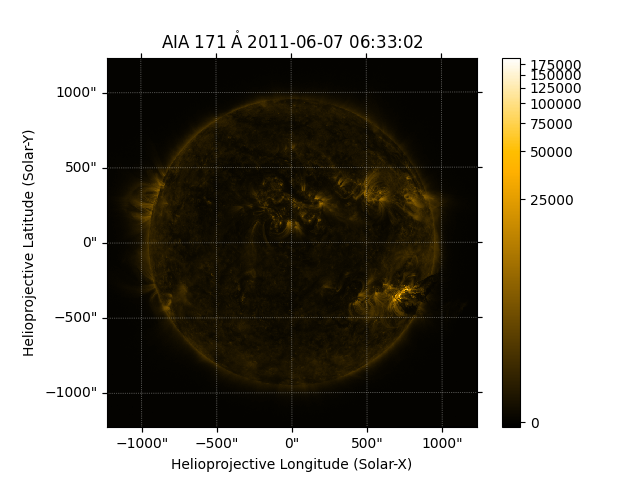

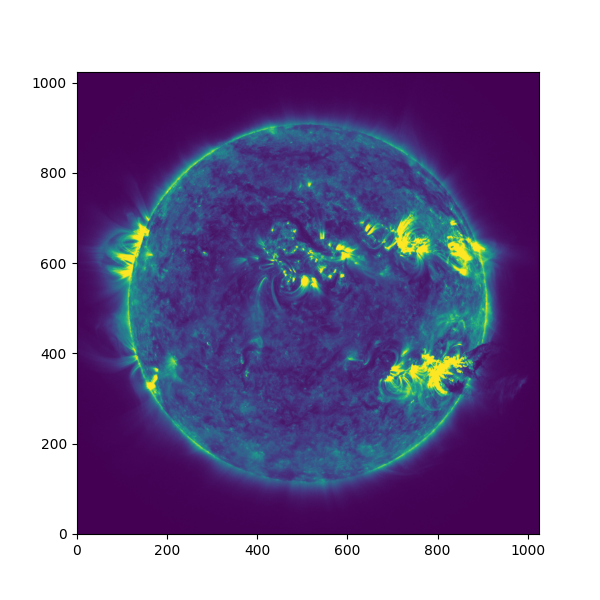

In [3]:
solar_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

data = solar_map.data

fig = plt.figure()
ax = fig.add_subplot(projection=solar_map)
solar_map.plot(axes=ax)
plt.colorbar()
plt.show()

tracer = InteractiveLoopTracer(data)
tracer.show()

In [9]:
plt.close('all')